In [1]:
import torch 
import torch.nn as nn
import torchvision
from torchvision import models
from torch.autograd import Variable
import torchvision.transforms as transforms
import numpy as np
from sklearn import metrics

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])


train_dataset = torchvision.datasets.MNIST(root = '../input/',
                                           train = True,
                                          transform = transform,
                                          download = True)

test_dataset = torchvision.datasets.MNIST(root = '../input/',
                                           train = False,
                                          transform = transform)

In [2]:
batch_size = 100
learning_rate = 0.05
num_epochs = 10

In [3]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size= batch_size, shuffle= True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size= batch_size, shuffle = False)

In [4]:
# 3*3 convolutino
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                    stride=stride, padding=1, bias=False)


# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(1, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 2)
        self.layer3 = self.make_layer(block, 64, layers[1], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [5]:
net_args = {
    "block": ResidualBlock,
    "layers": [2, 2, 2, 2]
}

model = ResNet(**net_args)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [6]:
model.to(device)

ResNet(
  (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [7]:
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/10], Step [100/600], Loss: 0.4347
Epoch [1/10], Step [200/600], Loss: 0.2603
Epoch [1/10], Step [300/600], Loss: 0.0890
Epoch [1/10], Step [400/600], Loss: 0.0408
Epoch [1/10], Step [500/600], Loss: 0.1355
Epoch [1/10], Step [600/600], Loss: 0.0609
Epoch [2/10], Step [100/600], Loss: 0.0417
Epoch [2/10], Step [200/600], Loss: 0.0726
Epoch [2/10], Step [300/600], Loss: 0.1123
Epoch [2/10], Step [400/600], Loss: 0.0964
Epoch [2/10], Step [500/600], Loss: 0.0393
Epoch [2/10], Step [600/600], Loss: 0.0054
Epoch [3/10], Step [100/600], Loss: 0.0037
Epoch [3/10], Step [200/600], Loss: 0.0390
Epoch [3/10], Step [300/600], Loss: 0.0158
Epoch [3/10], Step [400/600], Loss: 0.0635
Epoch [3/10], Step [500/600], Loss: 0.0380
Epoch [3/10], Step [600/600], Loss: 0.0210
Epoch [4/10], Step [100/600], Loss: 0.0608
Epoch [4/10], Step [200/600], Loss: 0.0167
Epoch [4/10], Step [300/600], Loss: 0.1030
Epoch [4/10], Step [400/600], Loss: 0.0031
Epoch [4/10], Step [500/600], Loss: 0.0661
Epoch [4/10

In [8]:
confusion_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size= 10000, shuffle = False)

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in confusion_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    pred = predicted.to('cpu')
    lb = labels.to('cpu')
    pred = np.array(pred)
    lb = np.array(lb)

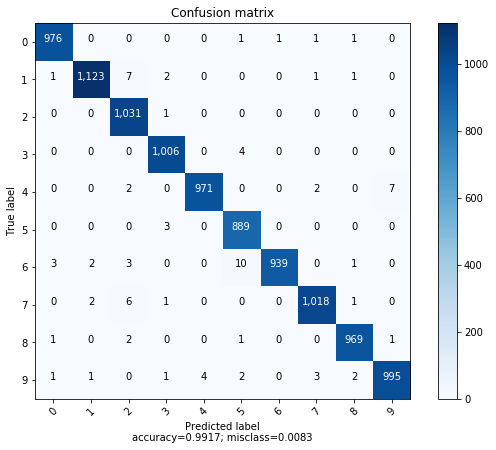

None


In [10]:
from cm_helper import plot_confusion_matrix

conf_matrix = metrics.confusion_matrix(lb, pred)
print(plot_confusion_matrix(conf_matrix,normalize =False,target_names=[0,1,2,3,4,5,6,7,8,9]))

In [11]:
print(f"The Accuracy : { 100 * metrics.accuracy_score(lb, pred)}")
print(f"The Precision : {100 * metrics.precision_score(lb, pred, average= 'macro')}")
print(f"The Recall : {100 * metrics.recall_score(lb, pred, average= 'macro')}")
print(f"The F1 Score : {100 *metrics.f1_score(lb, pred, average = 'macro')}")

The Accuracy : 99.17
The Precision : 99.16567129079239
The Recall : 99.17282227850876
The F1 Score : 99.16646309993983


In [ ]:
#https://www.kaggle.com/readilen/resnet-for-mnist-with-pytorch